In [1]:
import nltk
import pickle
import argparse
from collections import Counter, defaultdict
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import random

Using TensorFlow backend.


In [35]:
FLICKR_FOLDER = "data/flikr8k/"

In [36]:
# Paths to data
dir_Flickr_jpg = FLICKR_FOLDER+ "flickr8k_data/flicker_resized/"
dir_Flickr_train = FLICKR_FOLDER + "flickr8k_text/Flickr_8k.trainImages.txt"
dir_Flickr_valid = FLICKR_FOLDER + "flickr8k_text/Flickr_8k.devImages.txt"
dir_Flickr_test = FLICKR_FOLDER + "flickr8k_text/Flickr_8k.testImages.txt"
dir_Flickr_text = FLICKR_FOLDER + "flickr8k_text/Flickr8k.token.txt"
dir_Flickr_expert_annotations = FLICKR_FOLDER + "flickr8k_text/ExpertAnnotations.txt"

In [3]:
with open(dir_Flickr_train) as train_ids_f, open(dir_Flickr_valid) as valid_ids_f, open(dir_Flickr_test) as test_ids_f:
    train_ids = train_ids_f.readlines()
    valid_ids = valid_ids_f.readlines()
    test_ids = test_ids_f.readlines()

In [4]:
train_ids = train_ids + valid_ids
train_ids = list(map(lambda x: x.strip(), train_ids))
test_ids = list(map(lambda x: x.strip(), test_ids))
jpg_names = os.listdir(dir_Flickr_jpg)

In [5]:
# Create train and test sets {"img_id": [list of captions]}
train_set = defaultdict(list)
test_set = defaultdict(list)
full_set = defaultdict(list)
with open(dir_Flickr_text) as f:
    for line in f:
        img_id_n, caption_text = line.split("\t")
        caption_text = caption_text.strip()[:-2]
        img_id, cap_n = img_id_n.split("#")
        if '2258277193_586949ec62' in img_id: # Bug
            continue
        if img_id in train_ids:
            train_set[img_id].append((cap_n, caption_text))
        elif img_id in test_ids:
            test_set[img_id].append((cap_n, caption_text))
        else:
            train_set[img_id].append((cap_n, caption_text))
        full_set[img_id].append((cap_n, caption_text))

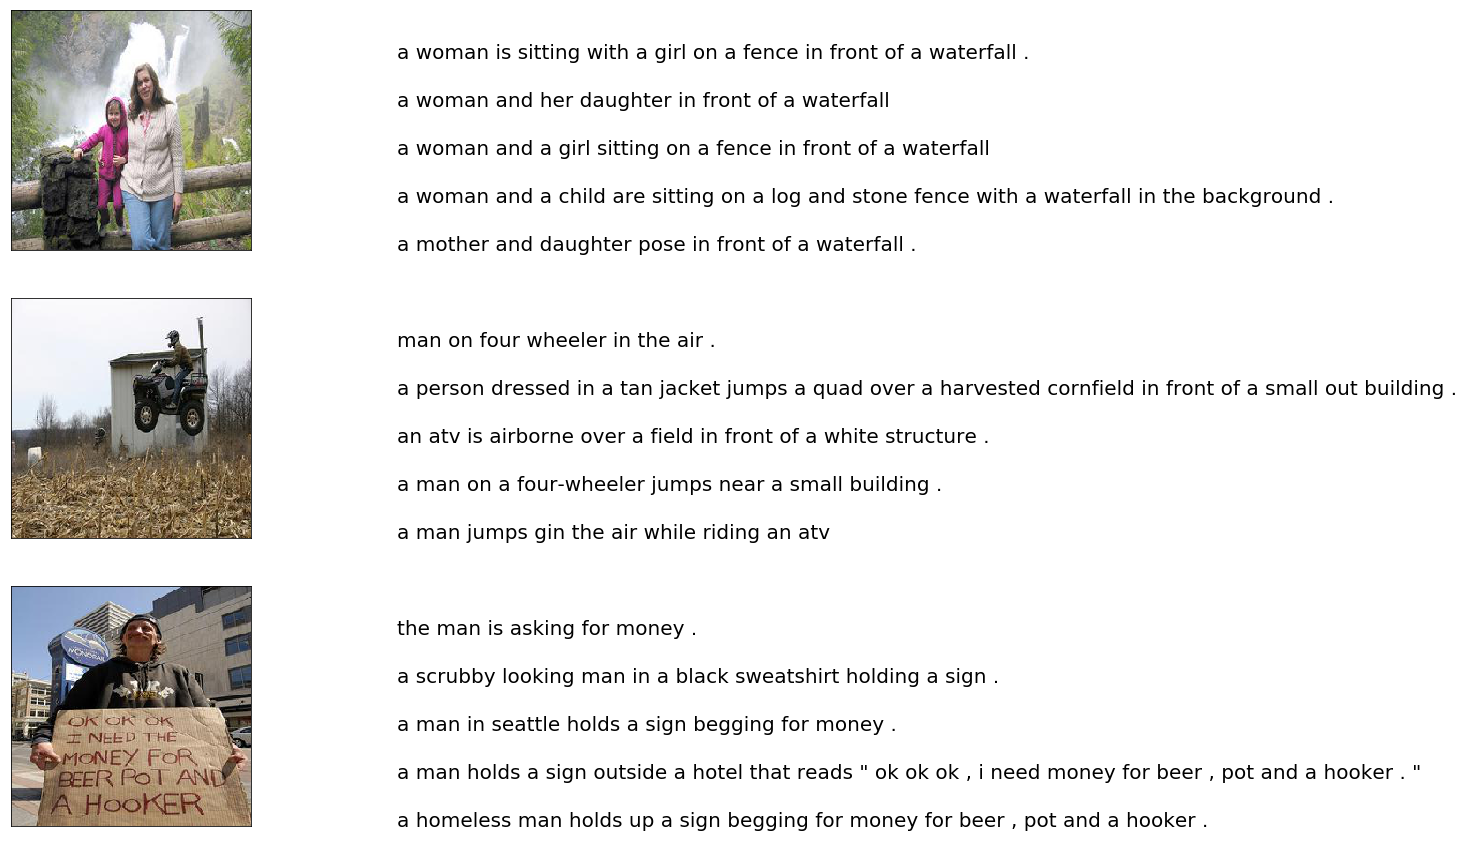

In [10]:
#
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
npic = 3
npix = 224
target_size = (npix,npix,3)
uni_filenames = np.unique(df_txt.filename.values)
count = 1
fig = plt.figure(figsize=(15,15))
rnd_files = uni_filenames
random.shuffle(uni_filenames)
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [11]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [20]:
# Create dictionary
counter = Counter()
threshold = 1
for i, img_id in enumerate(full_set.keys()):
    cap_n, caption = full_set[img_id][0]
    tokens = nltk.tokenize.word_tokenize(caption.lower())
    counter.update(tokens)

    if (i+1) % 1000 == 0:
        print("[{}/{}] Tokenized the captions.".format(i+1, len(full_set)))

words = [word for word, cnt in counter.items() if cnt >= threshold]
vocab = Vocabulary()
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')
for i, word in enumerate(words):
    vocab.add_word(word)

[1000/8091] Tokenized the captions.
[2000/8091] Tokenized the captions.
[3000/8091] Tokenized the captions.
[4000/8091] Tokenized the captions.
[5000/8091] Tokenized the captions.
[6000/8091] Tokenized the captions.
[7000/8091] Tokenized the captions.
[8000/8091] Tokenized the captions.


In [21]:
class Flickr8kDataset(data.Dataset):

    def __init__(self, root, defdic, vocab, transform=None):
        self.root = root
        self.defdic = defdic
        self.ids = list(self.defdic.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        vocab = self.vocab
        img_id = self.ids[index]
        caption = self.defdic[img_id][2][1]
        path = img_id
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)

In [22]:
def collate_fn(data):
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [23]:
def get_loader(root, defdic, vocab, transform, batch_size, shuffle, num_workers):
    # COCO caption dataset
    flickr8 = Flickr8kDataset(root=root,
                       defdic=defdic,
                       vocab=vocab,
                       transform=transform)
    data_loader = torch.utils.data.DataLoader(dataset=flickr8, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [24]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [25]:
transform_train = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [26]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(0.1)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
       # embeddings = self.dropout(embeddings)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

In [19]:
emb_size = 256
hidden_size = 512
num_layers = 2
lr = 0.001
n_epochs = 30
batch_size = 128

In [73]:
encoder = EncoderCNN(emb_size).to(device)
decoder = DecoderRNN(emb_size, hidden_size, len(vocab), num_layers).to(device)

In [74]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [75]:
data_loader_train = get_loader(dir_Flickr_jpg, train_set, vocab, transform_train, batch_size,
                               shuffle=True, num_workers=4)

data_loader_test = get_loader(dir_Flickr_jpg, test_set, vocab, transform_test, batch_size,
                               shuffle=True, num_workers=4)

In [76]:
total_step = len(data_loader_train)
train_loss_epoch = []
test_loss_epoch = []
for epoch in range(n_epochs):
    train_losses = []
    encoder = encoder.train()
    decoder = decoder.train()
    for i, (images, captions, lengths) in enumerate(data_loader_train):

        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        #print(outputs.shape, targets.shape)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.cpu().item())
    train_loss_epoch.append(np.mean(train_losses))
    
    encoder = encoder.eval()
    decoder = decoder.eval()
    test_losses = []
    for j, (test_images, test_captions, test_lengths) in enumerate(data_loader_test):
        test_images = test_images.to(device)
        test_captions = test_captions.to(device)
        test_targets = pack_padded_sequence(test_captions, test_lengths, 
                                            batch_first=True)[0]

        test_features = encoder(test_images)
        test_outputs = decoder(test_features, test_captions, test_lengths)

        test_loss = criterion(test_outputs, test_targets)
        test_losses.append(test_loss.cpu().item())
    test_loss_epoch.append(np.mean(test_losses))
        # Print log info
    print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1,
                                                                        n_epochs,
                                                                        train_loss_epoch[-1], 
                                                                        test_loss_epoch[-1]))

Epoch [1/30], Train Loss: 5.2666, Test Loss: 4.6214
Epoch [2/30], Train Loss: 4.1412, Test Loss: 3.9445
Epoch [3/30], Train Loss: 3.7351, Test Loss: 3.6645
Epoch [4/30], Train Loss: 3.4956, Test Loss: 3.5012
Epoch [5/30], Train Loss: 3.3249, Test Loss: 3.3852
Epoch [6/30], Train Loss: 3.1978, Test Loss: 3.2805
Epoch [7/30], Train Loss: 3.0846, Test Loss: 3.2210
Epoch [8/30], Train Loss: 2.9926, Test Loss: 3.1605
Epoch [9/30], Train Loss: 2.9028, Test Loss: 3.0937
Epoch [10/30], Train Loss: 2.8253, Test Loss: 3.0577
Epoch [11/30], Train Loss: 2.7553, Test Loss: 3.0349
Epoch [12/30], Train Loss: 2.6899, Test Loss: 2.9975
Epoch [13/30], Train Loss: 2.6269, Test Loss: 2.9671
Epoch [14/30], Train Loss: 2.5568, Test Loss: 2.9505
Epoch [15/30], Train Loss: 2.4931, Test Loss: 2.9363
Epoch [16/30], Train Loss: 2.4237, Test Loss: 2.9238
Epoch [17/30], Train Loss: 2.3621, Test Loss: 2.9218
Epoch [18/30], Train Loss: 2.2956, Test Loss: 2.8990
Epoch [19/30], Train Loss: 2.2264, Test Loss: 2.9035
Ep

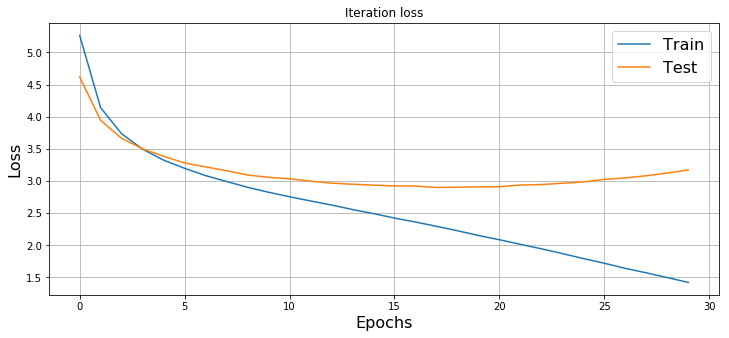

In [79]:
plt.figure(figsize=(12, 5))
plt.plot(train_loss_epoch, label='Train')
plt.plot(test_loss_epoch, label='Test')
plt.title("Iteration loss")
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

In [27]:
test_pics = list(train_set.keys())

In [28]:
test_img_id = test_pics[1]

In [29]:
train_set[test_img_id]

[('0', 'A black dog and a spotted dog are fighti'),
 ('1',
  'A black dog and a tri-colored dog playing with each other on the road'),
 ('2',
  'A black dog and a white dog with brown spots are staring at each other in the street'),
 ('3', 'Two dogs of different breeds looking at each other on the road'),
 ('4', 'Two dogs on pavement moving toward each other')]

In [30]:
test_img = Image.open(dir_Flickr_jpg + test_img_id)
#test_img = test_img.resize([224, 224], Image.LANCZOS)

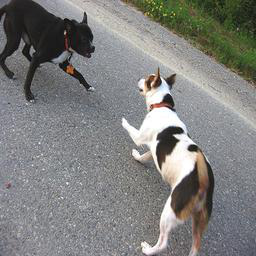

In [31]:
test_img

In [32]:
test_img_tensor = transform_test(test_img).unsqueeze(0).to(device)

In [33]:
test_img_tensor.shape

torch.Size([1, 3, 224, 224])

In [34]:
encoder = encoder.eval().to(device)

NameError: name 'encoder' is not defined

In [ ]:
feature = encoder(test_img_tensor)

In [127]:
sampled_ids = decoder.eval().to(device).sample(feature)

In [128]:
sampled_ids = sampled_ids[0].cpu().numpy()

In [129]:
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

In [130]:
sentence

'<start> a small black and white dog with a blue collar is jumping over a white fence <end>'